### Import libraries

In [1]:
import sys
sys.path.append("..")
from model import experimental_model, losses, grapher
from data import batch_creator, loader, data_generation, gp_kernels, gp_priors
from helpers import helpers, plotter, metrics
from keras.callbacks import ModelCheckpoint
from inference import infer
import tensorflow as tf; import keras
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
# options: rbf, periodic
print('Kernel? rbf/periodic')
kernel = input()
print('How many observations? (deafult 150000)')
dataset_size = input()
print('Do you want to overwrite data? True/False')
rewrite = input()
save_dir = '/Users/omernivron/Downloads/GPT_' + kernel

Kernel? rbf/periodic
rbf_3
How many observations? (deafult 150000)
150000
Do you want to overwrite data? True/False
True


In [ ]:
pad_pos_tr, pad_pos_te, em_te, em_tr, pad_y_fren_tr, pad_y_fren_te = loader.load_data(kernel, size = dataset_size, rewrite = rewrite.capitalize(), diff_x= True, noise =True)

Directory is empty 
 Generating data..
rbf


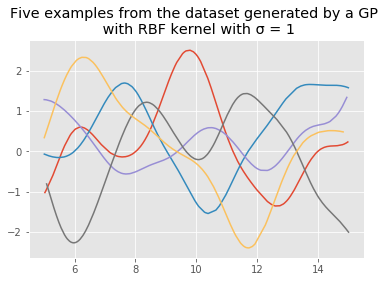

In [6]:
plotter.plot_examples(pad_pos_tr, pad_y_fren_tr)

In [5]:
### 10.67839196 --> 113
# (pad_pos_tr[12, :])[150]
# em_tr[12, :][150]

In [6]:
train_step, test_step, loss_object, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [7]:
# batch_pos_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_pos_tr, pad_y_fren_tr, batch_s=1)

Already exists
Restored from /Users/omernivron/Downloads/GPT_rbf_2/ckpt/check_run_1/ckpt-9


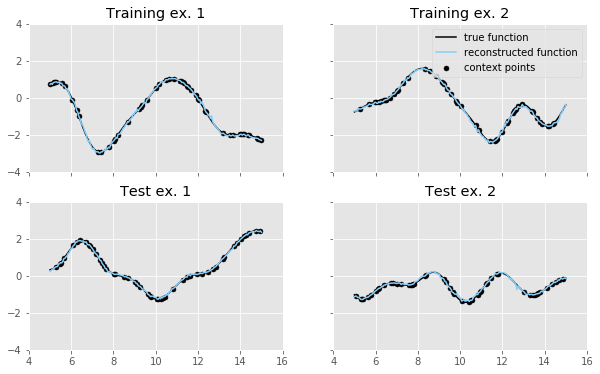

Epoch 0 batch 0 train Loss -1.0652 test Loss -1.0403 with training MSE metric 0.0031 and testing MSE metric 0.0034
learning rate is 0.0003000000142492354
r squared training:  tf.Tensor(0.99599636, shape=(), dtype=float32)
r squared testing:  tf.Tensor(0.9956984, shape=(), dtype=float32)


KeyboardInterrupt: 

In [8]:
if __name__ == '__main__':
    EPOCHS = 75; batch_s  = 64; run = 1; step = 0; train_steps = 35000; heads = 32; ℯ = 512
    l = [256, 256, 64, 32]
    name_comp = 'run_' + str(run) #+ '_heads_' + str(heads) + '_encoding_' + str(ℯ)
    logdir = save_dir + '/logs/' + name_comp
    writer = tf.summary.create_file_writer(logdir)
    folder = save_dir + '/ckpt/check_' + name_comp; 
    lr_fn = tf.optimizers.schedules.PolynomialDecay(9e-3, train_steps, 1e-7, 2)
    optimizer_c = tf.keras.optimizers.Adam(3e-4)
    ℯ, l1, l2, l3, l4 = helpers.load_spec(folder, ℯ, l); 
    helpers.mkdir(folder)
    decoder = experimental_model.Decoder(ℯ, l1, l2, l3, l4, num_heads = heads); tf.random.set_seed(443)   
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
#     optimizer_c = tf.keras.optimizers.Adam(3e-4)
    with writer.as_default():
        for epoch in range(EPOCHS):

            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                b_em_tr, batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(em_tr, pad_pos_tr, pad_y_fren_tr, batch_s=64)
                pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, b_em_tr, batch_tar_tr)
                if ((epoch == 0) & (batch_n == 0)): helpers.write_speci(folder, names, shapes)
                if batch_n % 300 == 0:
                    m_te.reset_states(); test_loss.reset_states()
                    pred_te, pred_log_te = test_step(decoder, test_loss, m_te, em_te[:500, :], pad_y_fren_te[:500, :])
                    plotter.follow_training_plot(batch_pos_tr, batch_tar_tr, pred, pad_pos_te[:500, :], pad_y_fren_te[:500, :], pred_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    print('learning rate is {}'.format(optimizer_c._decayed_lr('float32').numpy()))
                    print('r squared training: ', metrics.r_squared(m_tr.result(), batch_tar_tr[:, 51:]))
                    print('r squared testing: ', metrics.r_squared(m_te.result(), pad_y_fren_te[:500, 51:], batch_s = 500))


                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



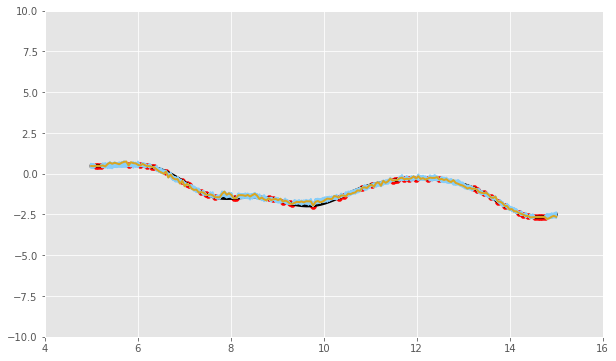

In [9]:
plotter.infer_plot(decoder, em_te, pad_pos_te, pad_y_fren_te, 150, np.array([7931]), samples = 50)

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [4]:
from sklearn.gaussian_process.kernels import WhiteKernel

In [5]:
k  = WhiteKernel(.11)

In [6]:
gp = GaussianProcessRegressor(kernel=k)

In [9]:
import numpy as np 

In [10]:
X_ = np.linspace(0, 5, 100)

In [13]:
gp.sample_y(X_[:, np.newaxis], 1)[0, :]

array([0.58506997])

Text(0.5, 1.0, 'Prior (kernel:  WhiteKernel(noise_level=1))')

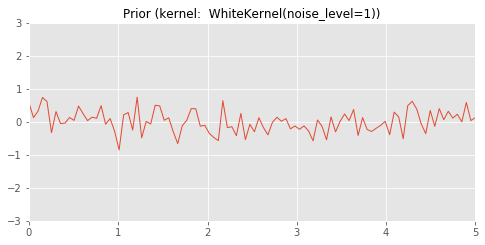

In [16]:
# Plot prior
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
X_ = np.linspace(0, 5, 100)
# y_mean= gp.sample_y(X_[:, np.newaxis])
# plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
# plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
#                  alpha=0.2, color='k')
y_samples = gp.sample_y(X_[:, np.newaxis], 1)
plt.plot(X_, y_samples, lw=1)
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)